In [27]:
# Kütüphaneleri yükleme:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install transformers torch scikit-learn pandas seaborn matplotlib

# kütüphaneleri import etme:
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [28]:
#GPU'yu Etkinleştirme:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Cihazı: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU kullanılamıyor, CPU ile devam ediliyor.")

GPU Cihazı: Tesla T4


In [76]:
# veri setini yükleme
drive.mount('/content/drive')
dosya_yolu = "/content/drive/MyDrive/Colab/500_3860.csv"
df= pd.read_csv(dosya_yolu, sep=';', on_bad_lines='skip')
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4360 entries, 0 to 4359
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Yorum                   4359 non-null   object
 1   Sahte [0] / Gerçek [1]  4360 non-null   int64 
 2   urun                    4360 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.3+ KB


In [77]:
# Eksik değerleri kontrol etme
print(df['Yorum'].isnull().sum())

# Eksik veya NaN değerleri boş bir string ile doldurma
df['Yorum'] = df['Yorum'].fillna("")

1


In [ ]:
"""# şimdi özel karakter temizleme işlemi:
def temizle(text):
  text=re.sub(r'[^\w\s,.:;!?]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text
  df['review_text'] = df['review_text'].apply(temizle)
df.head()"""

,Yorum,Sahte [0] / Gerçek [1],urun
0,Çok erken bozuldu garanti ile uğraşmadım ama m...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
1,Çok beğendik harika köpüklü yapıyor fiyat perf...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
2,cok beğendim paketleme de çok güzeldi fiyatına...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
3,ürün iki kullanışta bozultu,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
4,Bol köpüklü güzel yapıyor,1,AWOX Rosegold -mavi Kafija Kahve Makinesi


In [ ]:
"""#Yorum Temizleme ve Lemmatizasyon Fonksiyonu
nltk.download('wordnet') # wordnet datasını indirildi
nltk.download('omw-1.4')  # Eğer Türkçe desteği gerekliyse
lemmatizer = WordNetLemmatizer()

def temizle_ve_lemmatize(text):
    text = re.sub(r'[^\w\s,.:;!?]', '', text)  # Özel karakterler kaldırıldı
    text = re.sub(r'\s+', ' ', text).strip()  # Fazla boşluklar kaldırıldı
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatizasyon uygulanır
    return ' '.join(lemmatized_words)

df['Yorum'] = df['Yorum'].apply(temizle_ve_lemmatize)"""


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [78]:
# Stopword seti ve lemmatizer tanımları
nltk.download('wordnet') # wordnet datasını indirildi
nltk.download('omw-1.4')  # Eğer Türkçe desteği gerekliyse
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))  # Türkçe için 'turkish' kullanılabilir
lemmatizer = WordNetLemmatizer()

def temizle_ve_lemmatize(text):
    text = re.sub(r'[^\w\s]', '', text)  # Özel karakterler kaldırılır
    words = text.split()
    # Stopword ve lemmatizasyon aynı anda uygulanır
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# Örnek kullanım
df['Yorum'] = df['Yorum'].apply(temizle_ve_lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
"""# şimdi özel karakter temizleyelim:
# Stopwords ve Temizleme Fonksiyonu:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('turkish'))
def temizle(text):
  text=re.sub(r'[^\w\s,.:;!?]', '', text) # Özel karakterleri kaldır
  text = re.sub(r'\s+', ' ', text).strip() # Fazla boşlukları kaldır
  tokens = word_tokenize(text) # Tokenize işlemi
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words] # Stopwords çıkarma
  text = ' '.join(filtered_tokens)  # Kelimeleri tekrar birleştirme
  return text
  df['Yorum'] = df['Yorum'].apply(temizle)
df.head()"""

,Yorum,Sahte [0] / Gerçek [1],urun
0,Çok erken bozuldu garanti ile uğraşmadım ama m...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
1,Çok beğendik harika köpüklü yapıyor fiyat perf...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
2,cok beğendim paketleme de çok güzeldi fiyatına...,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
3,ürün iki kullanışta bozultu,1,AWOX Rosegold -mavi Kafija Kahve Makinesi
4,Bol köpüklü güzel yapıyor,1,AWOX Rosegold -mavi Kafija Kahve Makinesi


In [79]:
# verimiz modele hazır mı? veri ön işlemenin son adımı.
# Yorumlar ve etiketleri ayırıyoruz
yorumlar = df['Yorum'].tolist()
etiketler = df['Sahte [0] / Gerçek [1]'].tolist()
label_counts = df['Sahte [0] / Gerçek [1]'].value_counts()
print("Etiket Sayıları:")
print(label_counts)

#Modeli eğitmek için veri setini ikiye böleceğiz: eğitim (%80) ve test (%20) ve split fonksiyonunu kullanacağız.
from sklearn.model_selection import train_test_split
yorum_train, yorum_test, etiket_train, etiket_test = train_test_split(yorumlar, etiketler, test_size=0.2, random_state=42)
#Sonuç: Evet veri setimiz şu an modelimize hazır.

Etiket Sayıları:
Sahte [0] / Gerçek [1]
1    3860
0     500
Name: count, dtype: int64


In [80]:
# 1) MODELİ VE TOKENZERİ YÜKLEME:
# dbmdz/bert-base-turkish-cased : bu model kullanılacaktır.
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
print(type(yorum_train))
print(type(yorum_test))

<class 'list'>
<class 'list'>


In [82]:
yorum_train = [str(yorum) for yorum in yorum_train]
yorum_test = [str(yorum) for yorum in yorum_test]

In [83]:
print(type(yorum_train))
print(type(yorum_test))

<class 'list'>
<class 'list'>


In [84]:
# veriyi tokenize etme işlemi:
train_encodings = tokenizer(yorum_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(yorum_test, truncation=True, padding=True, max_length=128)

In [85]:
#Tokenize edilmiş veriyi PyTorch Dataset formatına dönüştürme.
class YorumDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
        for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

etiket_train = torch.tensor(etiket_train, dtype=torch.long)
etiket_test = torch.tensor(etiket_test, dtype=torch.long)

train_dataset = YorumDataset(train_encodings, etiket_train)
test_dataset = YorumDataset(test_encodings, etiket_test)

In [86]:
#PyTorch DataLoader ile veriyi modelinize gönderin ve eğitimi başlatın.
#dataloader:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

#modelin eğitimi:
optimizer = AdamW(model.parameters(), lr=5e-5)
model.to(device)
model.train()
for epoch in range(5):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/218 [00:00<?, ?it/s]<ipython-input-85-1adfd7806f65>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
Epoch 4: 100%|██████████| 218/218 [01:15<00:00,  2.90it/s, loss=0.00989]


In [87]:
# sınıflandırma metrikleri ile model değerlendirmesi:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)
print(classification_report(true_labels, predictions))

<ipython-input-85-1adfd7806f65>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


              precision    recall  f1-score   support

           0       0.76      0.62      0.68       100
           1       0.95      0.97      0.96       772

    accuracy                           0.93       872
   macro avg       0.85      0.80      0.82       872
weighted avg       0.93      0.93      0.93       872



In [88]:
# Test verisini Train ile eşleştirme ve hata hesaplaması
# Eğitim verisi üzerinden öngörüler
train_predictions = []
train_true_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        train_predictions.extend(preds)
        train_true_labels.extend(labels)

train_cm = confusion_matrix(train_true_labels, train_predictions)
train_accuracy = (train_cm[0][0] + train_cm[1][1]) / train_cm.sum()
train_error_rate = 1 - train_accuracy

print("Eğitim Verisi Performansı:")
print(f"Accuracy: {train_accuracy:.4f}, Error Rate: {train_error_rate:.4f}")


<ipython-input-85-1adfd7806f65>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Eğitim Verisi Performansı:
Accuracy: 0.9911, Error Rate: 0.0089


In [90]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Hesaplamalar
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
error_rate = 1 - accuracy
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

TP: 752, FP: 38, TN: 62, FN: 20
Accuracy: 0.9335, Error Rate: 0.0665
Precision: 0.9519, Recall: 0.9741, F1-Score: 0.9629


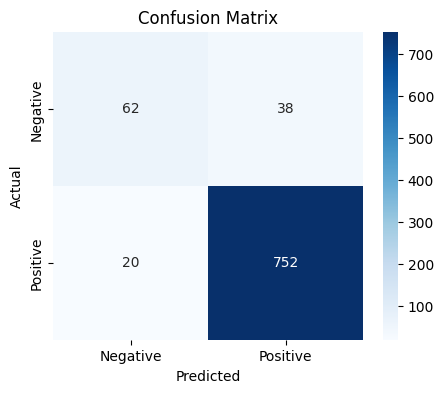

In [91]:
# Confusion matrix'i görselleştirme
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()